In [1]:
%matplotlib inline

import book_format
book_format.set_style()

from numpy.random import randn

class PosSensor(object):
    def __init__(self, pos=(0, 0), vel=(0, 0), noise_std=1.):
        self.vel = vel
        self.noise_std = noise_std
        self.pos = [pos[0], pos[1]]
        
    def read(self):
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]
        
        return [self.pos[0] + randn() * self.noise_std,
                self.pos[1] + randn() * self.noise_std]

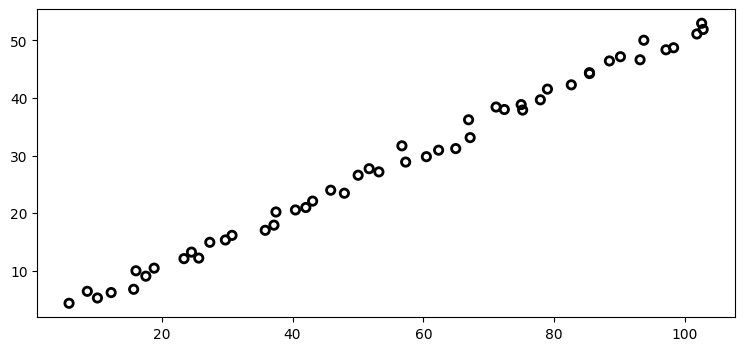

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from kf_book.book_plots import plot_measurements

pos, vel = (4, 3), (2, 1)
sensor = PosSensor(pos, vel, noise_std=1)
ps = np.array([sensor.read() for _ in range(50)])
plot_measurements(ps[:, 0], ps[:, 1]);

In [4]:
from filterpy.kalman import KalmanFilter

tracker = KalmanFilter(dim_x=4, dim_z=2)
dt = 1.   # time step 1 second

tracker.F = np.array([[1, dt, 0,  0],
                      [0,  1, 0,  0],
                      [0,  0, 1, dt],
                      [0,  0, 0,  1]])


from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

q = Q_discrete_white_noise(dim=2, dt=dt, var=0.001)
tracker.Q = block_diag(q, q)
print(tracker.Q)

[[0.    0.001 0.    0.   ]
 [0.001 0.001 0.    0.   ]
 [0.    0.    0.    0.001]
 [0.    0.    0.001 0.001]]


In [5]:
tracker.B

In [6]:
tracker.H = np.array([[1/0.3048, 0, 0,        0],
                      [0,        0, 1/0.3048, 0]])

In [7]:
tracker.R = np.array([[5., 0],
                      [0, 5]])
tracker.R

array([[5., 0.],
       [0., 5.]])

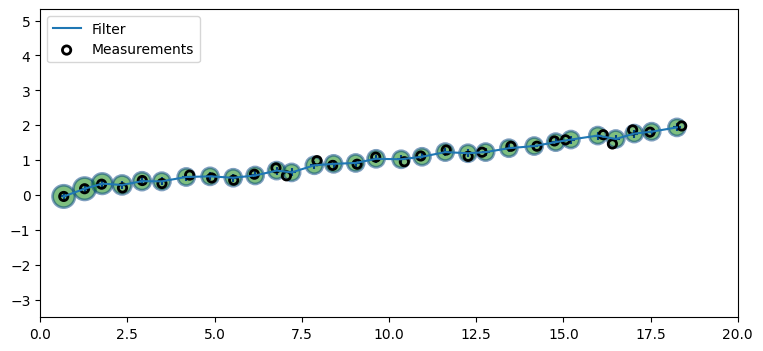

In [9]:
tracker.x = np.array([[0, 0, 0, 0]]).T
tracker.P = np.eye(4) * 500.

from filterpy.stats import plot_covariance_ellipse
from kf_book.book_plots import plot_filter

R_std = 0.35
Q_std = 0.04

def tracker1():
    tracker = KalmanFilter(dim_x=4, dim_z=2)
    dt = 1.0   # time step

    tracker.F = np.array([[1, dt, 0,  0],
                          [0,  1, 0,  0],
                          [0,  0, 1, dt],
                          [0,  0, 0,  1]])
    tracker.u = 0.
    tracker.H = np.array([[1/0.3048, 0, 0, 0],
                          [0, 0, 1/0.3048, 0]])

    tracker.R = np.eye(2) * R_std**2
    q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_std**2)
    tracker.Q = block_diag(q, q)
    tracker.x = np.array([[0, 0, 0, 0]]).T
    tracker.P = np.eye(4) * 500.
    return tracker

# simulate robot movement
N = 30
sensor = PosSensor((0, 0), (2, .2), noise_std=R_std)

zs = np.array([sensor.read() for _ in range(N)])

# run filter
robot_tracker = tracker1()
mu, cov, _, _ = robot_tracker.batch_filter(zs)

for x, P in zip(mu, cov):
    # covariance of x and y
    cov = np.array([[P[0, 0], P[2, 0]], 
                    [P[0, 2], P[2, 2]]])
    mean = (x[0, 0], x[2, 0])
    plot_covariance_ellipse(mean, cov=cov, fc='g', std=3, alpha=0.5)
    
#plot results
zs *= .3048 # convert to meters
plot_filter(mu[:, 0], mu[:, 2])
plot_measurements(zs[:, 0], zs[:, 1])
plt.legend(loc=2)
plt.xlim(0, 20);

[[0.007 0.003]
 [0.003 0.003]]


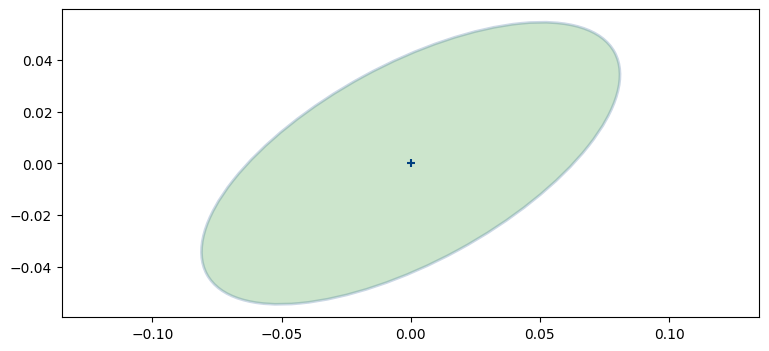

In [10]:
c = robot_tracker.P[0:2, 0:2]
print(c)
plot_covariance_ellipse((0, 0), cov=c, fc='g', alpha=0.2)

In [11]:
robot_tracker.P[2:4, 0:2]

array([[0., 0.],
       [0., 0.]])

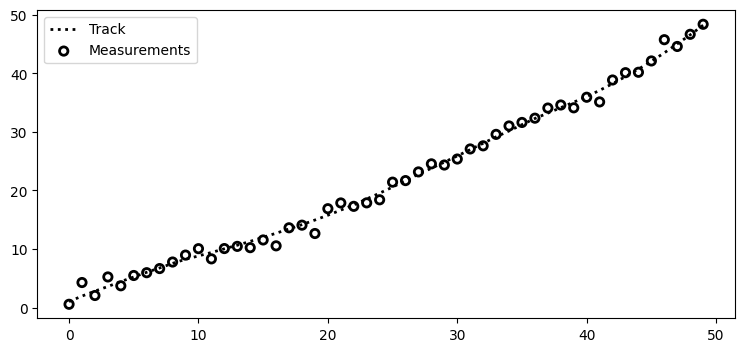

In [12]:
from kf_book.book_plots import plot_track

class ConstantVelocityObject(object):
    def __init__(self, x0=0, vel=1., noise_scale=0.06):
        self.x = x0
        self.vel = vel
        self.noise_scale = noise_scale

    def update(self):
        self.vel += randn() * self.noise_scale
        self.x += self.vel
        return (self.x, self.vel)

def sense(x, noise_scale=1.):
    return x[0] + randn()*noise_scale

np.random.seed(124)
obj = ConstantVelocityObject()

xs, zs = [], []
for i in range(50):
    x = obj.update()
    z = sense(x)
    xs.append(x)
    zs.append(z)

xs = np.asarray(xs)

plot_track(xs[:, 0])
plot_measurements(range(len(zs)), zs)
plt.legend(loc='best');

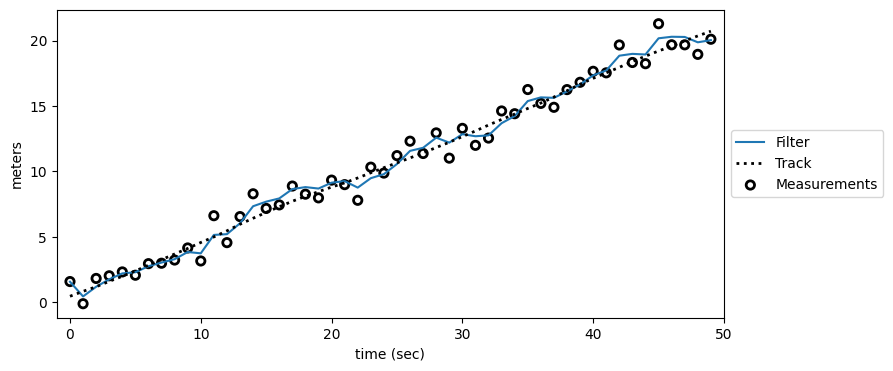

In [14]:
def ZeroOrderKF(R, Q, P=20):
    """ Create zero order Kalman filter.
    Specify R and Q as floats."""
    
    kf = KalmanFilter(dim_x=1, dim_z=1)
    kf.x = np.array([0.])
    kf.R *= R
    kf.Q *= Q
    kf.P *= P
    kf.F = np.eye(1)
    kf.H = np.eye(1)
    return kf

def FirstOrderKF(R, Q, dt):
    """ Create first order Kalman filter. 
    Specify R and Q as floats."""
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.zeros(2)
    kf.P *= np.array([[100, 0], [0, 1]])
    kf.R *= R
    kf.Q = Q_discrete_white_noise(2, dt, Q)
    kf.F = np.array([[1., dt],
                     [0., 1]])
    kf.H = np.array([[1., 0]])
    return kf

def SecondOrderKF(R_std, Q, dt, P=100):
    """ Create second order Kalman filter. 
    Specify R and Q as floats."""
    
    kf = KalmanFilter(dim_x=3, dim_z=1)
    kf.x = np.zeros(3)
    kf.P[0, 0] = P
    kf.P[1, 1] = 1
    kf.P[2, 2] = 1
    kf.R *= R_std**2
    kf.Q = Q_discrete_white_noise(3, dt, Q)
    kf.F = np.array([[1., dt, .5*dt*dt],
                     [0., 1.,       dt],
                     [0., 0.,       1.]])
    kf.H = np.array([[1., 0., 0.]])
    return kf

def simulate_system(Q, count):
    obj = ConstantVelocityObject(x0=.0, vel=0.5, noise_scale=Q)
    xs, zs = [], []
    for i in range(count):
        x = obj.update()
        z = sense(x)
        xs.append(x)
        zs.append(z)
    return np.array(xs), np.array(zs)



from filterpy.common import Saver

def filter_data(kf, zs):
    s = Saver(kf)
    kf.batch_filter(zs, saver=s)
    s.to_array()
    return s

from kf_book.book_plots import plot_kf_output

R, Q = 1, 0.03
xs, zs = simulate_system(Q=Q, count=50)

kf = FirstOrderKF(R, Q, dt=1)
data1 = filter_data(kf, zs)

plot_kf_output(xs, data1.x, data1.z)

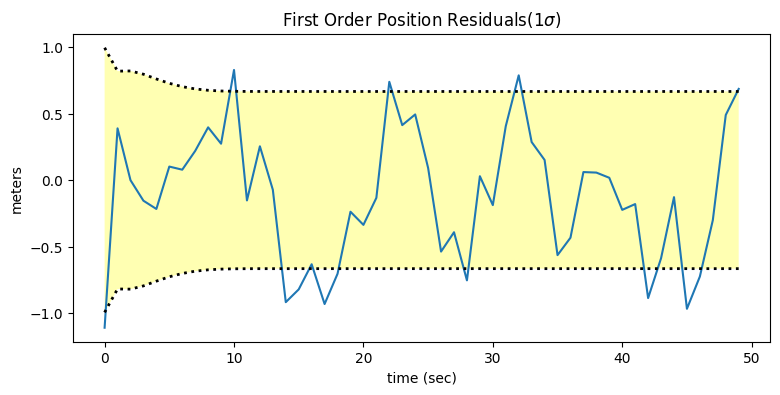

In [15]:
from kf_book.book_plots import plot_residual_limits, set_labels

def plot_residuals(xs, data, col, title, y_label, stds=1):
    res = xs - data.x[:, col]
    plt.plot(res)
    plot_residual_limits(data.P[:, col, col], stds)
    set_labels(title, 'time (sec)', y_label)
    

plot_residuals(xs[:, 0], data1, 0, 
               title='First Order Position Residuals(1$\sigma$)',
               y_label='meters')   

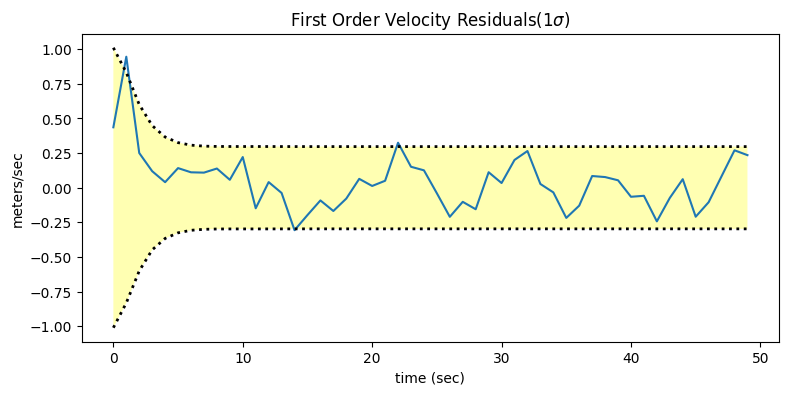

In [16]:
plot_residuals(xs[:, 1], data1, 1, 
               title='First Order Velocity Residuals(1$\sigma$)',
               y_label='meters/sec')   

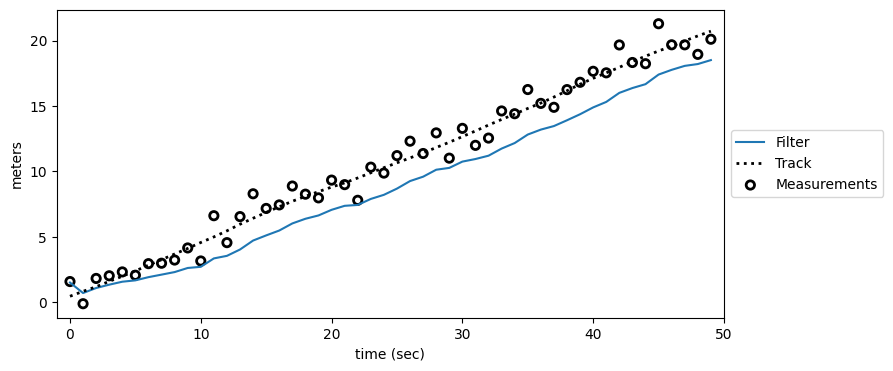

In [17]:
kf0 = ZeroOrderKF(R, Q)
data0 = filter_data(kf0, zs)
plot_kf_output(xs, data0.x, data0.z)

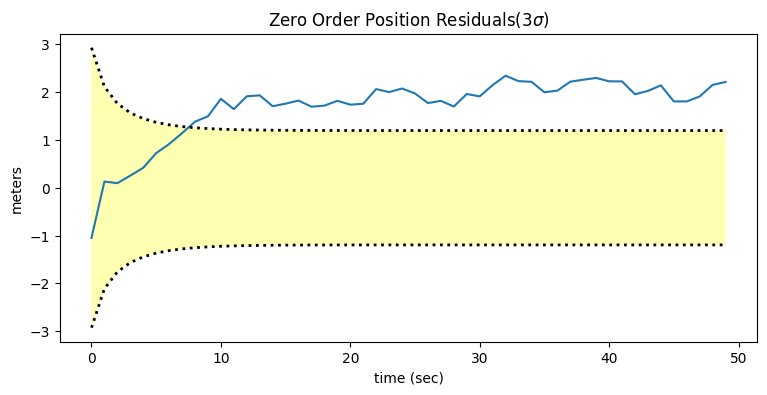

In [18]:
plot_residuals(xs[:, 0], data0, 0, 
               title='Zero Order Position Residuals(3$\sigma$)',
               y_label='meters',
               stds=3)

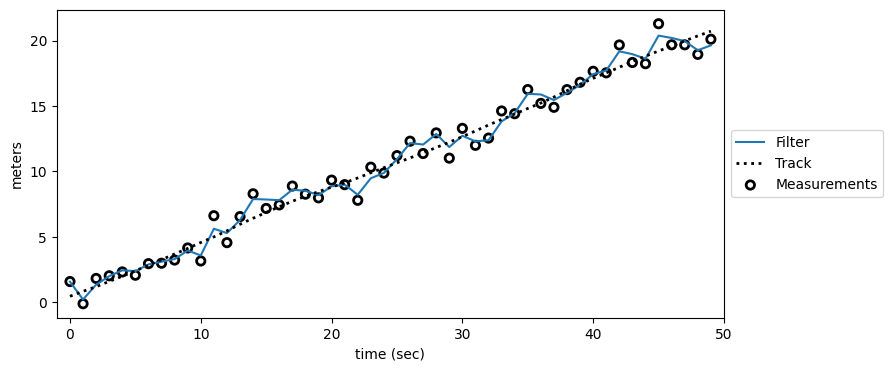

In [19]:
kf2 = SecondOrderKF(R, Q, dt=1)
data2 = filter_data(kf2, zs)
plot_kf_output(xs, data2.x, data2.z)

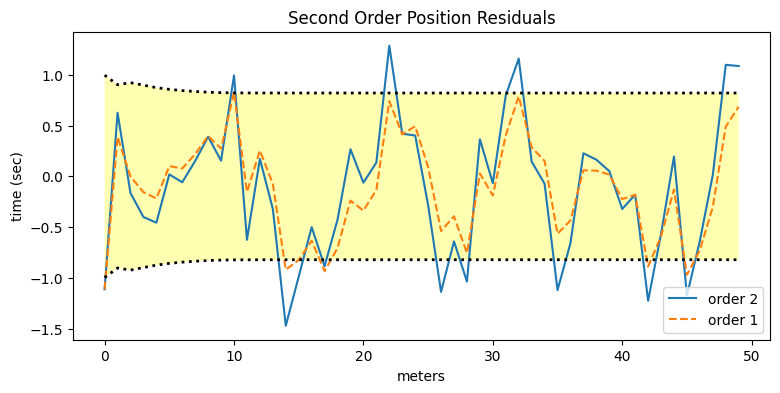

In [20]:
res2 = xs[:, 0] - data2.x[:, 0]
res1 = xs[:, 0] - data1.x[:, 0]

plt.plot(res2, label='order 2')
plt.plot(res1, ls="--", label='order 1')
plot_residual_limits(data2.P[:, 0, 0])
set_labels('Second Order Position Residuals',
           'meters', 'time (sec)')
plt.legend();

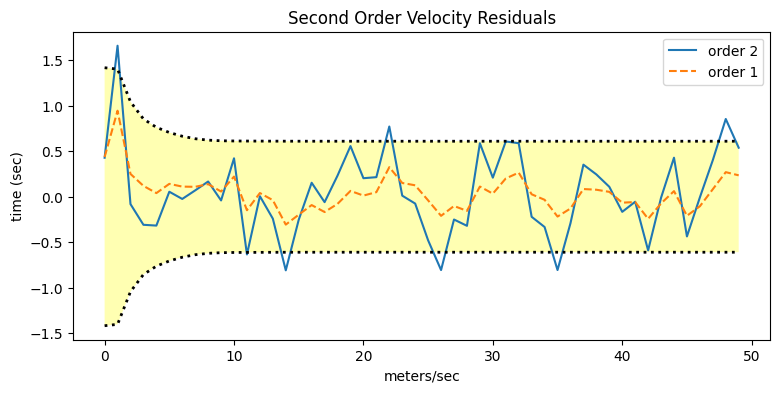

In [21]:
res2 = xs[:, 1] - data2.x[:, 1]
res1 = xs[:, 1] - data1.x[:, 1]

plt.plot(res2, label='order 2')
plt.plot(res1, ls='--', label='order 1')
plot_residual_limits(data2.P[:, 1, 1])
set_labels('Second Order Velocity Residuals', 
                      'meters/sec', 'time (sec)')
plt.legend();

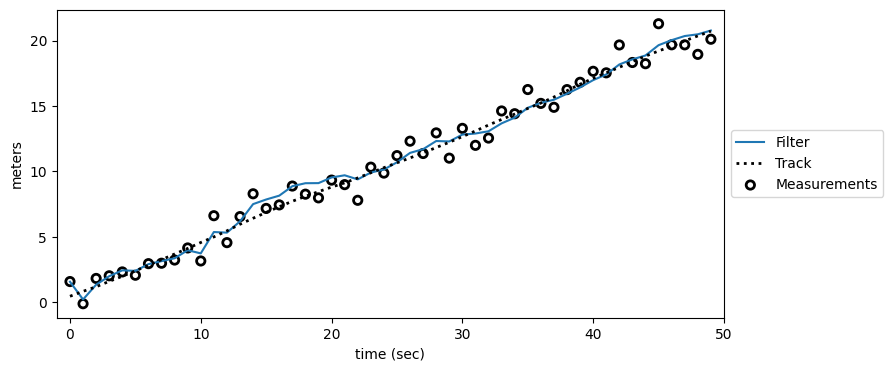

In [22]:
kf2 = SecondOrderKF(R, 0, dt=1)
data2 = filter_data(kf2, zs)
plot_kf_output(xs, data2.x, data2.z)

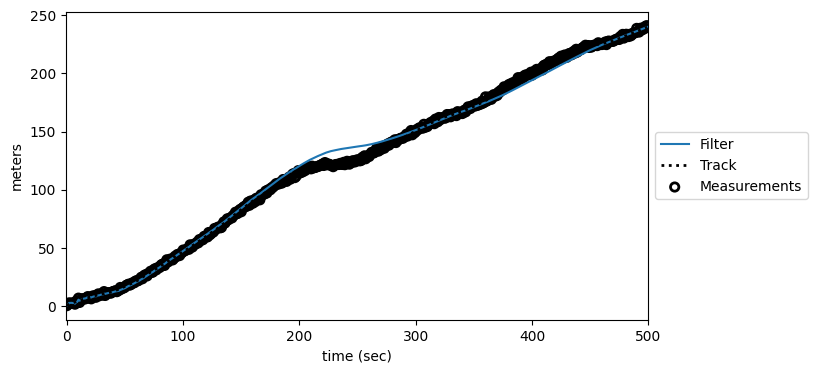

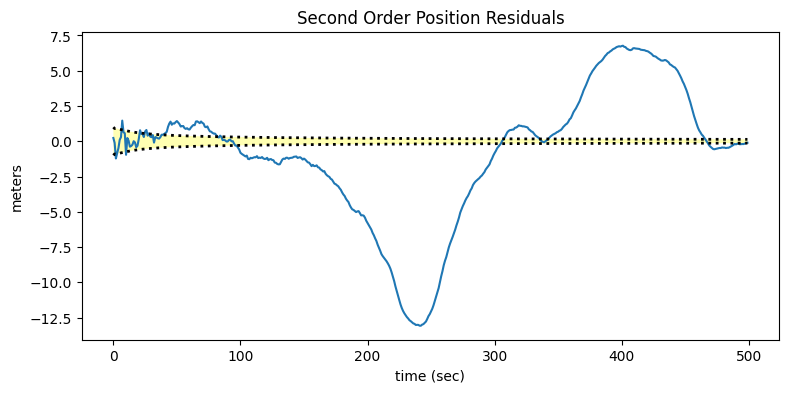

In [23]:
np.random.seed(25944)
xs500, zs500 = simulate_system(Q=Q, count=500)

kf2 = SecondOrderKF(R, 0, dt=1)
data500 = filter_data(kf2, zs500)

plot_kf_output(xs500, data500.x, data500.z)
plot_residuals(xs500[:, 0], data500, 0, 
               'Second Order Position Residuals',
               'meters') 

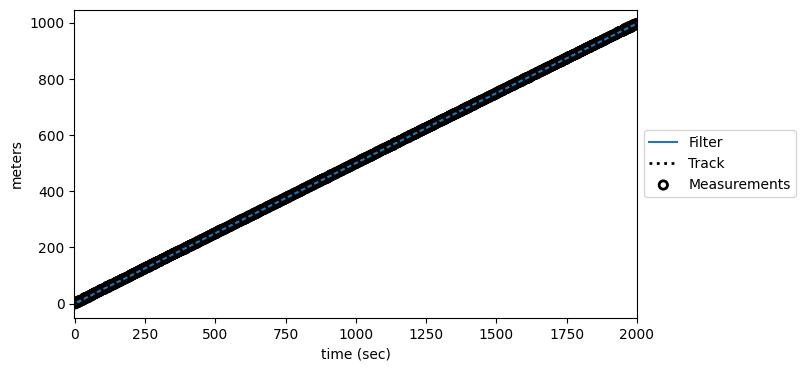

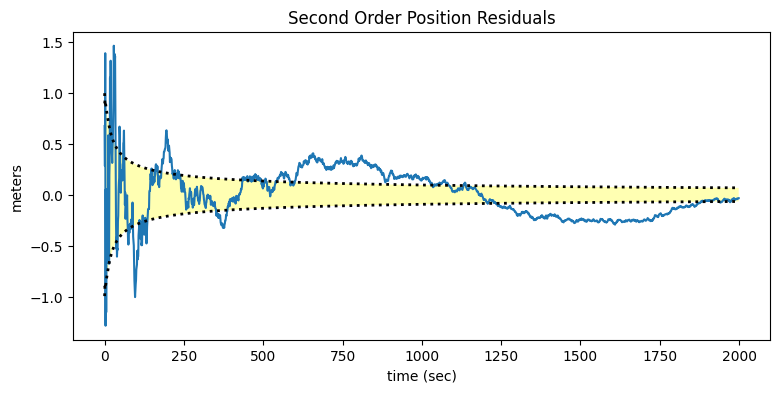

In [24]:
np.random.seed(32594)
xs2000, zs2000 = simulate_system(Q=0.0001, count=2000)

kf2 = SecondOrderKF(R, 0, dt=1)
data2000 = filter_data(kf2, zs2000)

plot_kf_output(xs2000, data2000.x, data2000.z)
plot_residuals(xs2000[:, 0], data2000, 0, 
               'Second Order Position Residuals',
               'meters') 

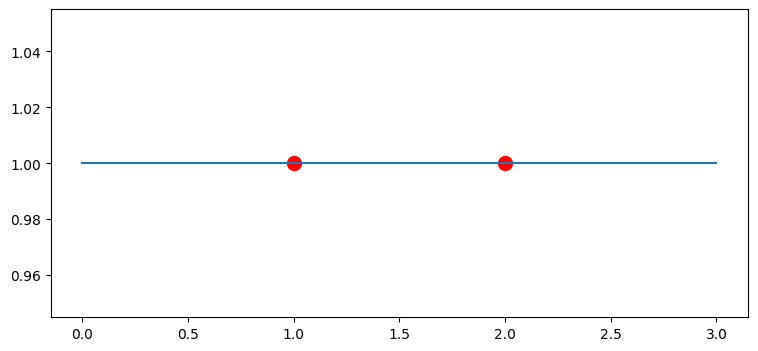

In [25]:
plt.scatter([1, 2], [1, 1], s=100, c='r')
plt.plot([0, 3], [1, 1]);

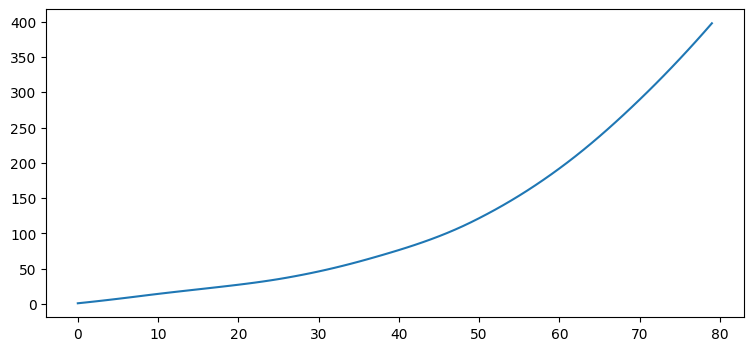

In [26]:
class ConstantAccelerationObject(object):
    def __init__(self, x0=0, vel=1., acc=0.1, acc_noise=.1):
        self.x = x0
        self.vel = vel
        self.acc = acc
        self.acc_noise_scale = acc_noise
    
    def update(self):
        self.acc += randn() * self.acc_noise_scale       
        self.vel += self.acc
        self.x += self.vel
        return (self.x, self.vel, self.acc)
  
R, Q = 6., 0.02
def simulate_acc_system(R, Q, count):
    obj = ConstantAccelerationObject(acc_noise=Q)
    zs = []
    xs = []
    for i in range(count):
        x = obj.update()
        z = sense(x, R)
        xs.append(x)
        zs.append(z)
    return np.asarray(xs), zs

np.random.seed(124)
xs, zs = simulate_acc_system(R=R, Q=Q, count=80)
plt.plot(xs[:, 0]);

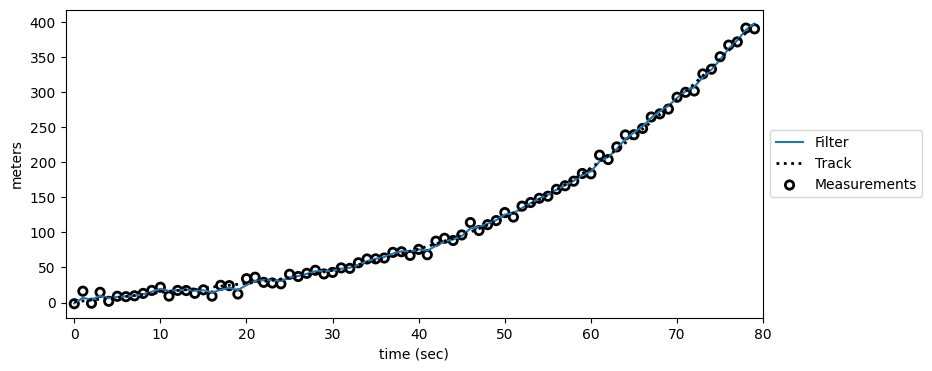

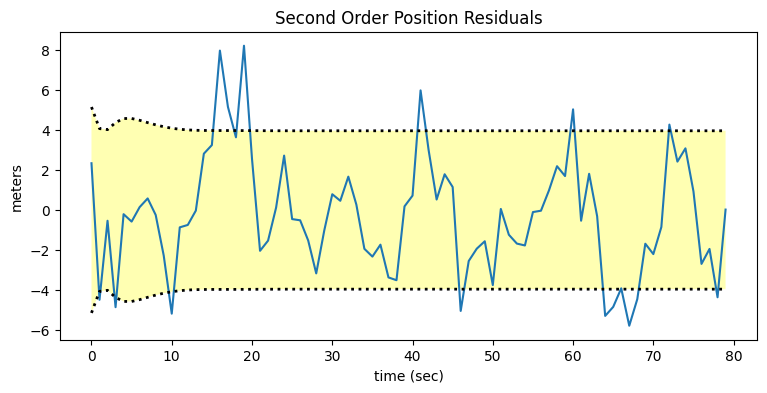

In [27]:
np.random.seed(124)
xs, zs = simulate_acc_system(R=R, Q=Q, count=80)

kf2 = SecondOrderKF(R, Q, dt=1)
data2 = filter_data(kf2, zs)

plot_kf_output(xs, data2.x, data2.z, aspect_equal=False)
plot_residuals(xs[:, 0], data2, 0, 
               'Second Order Position Residuals',
               'meters') 

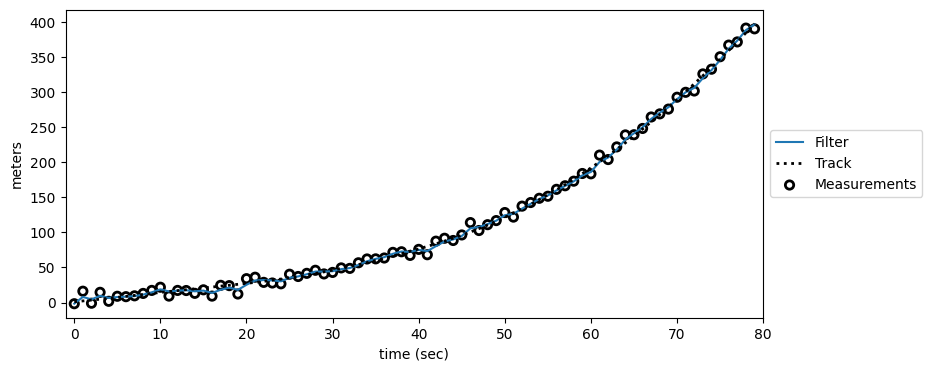

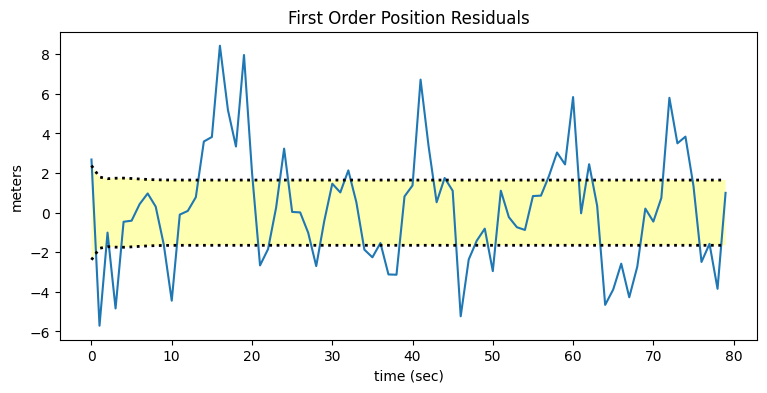

In [28]:
kf3 = FirstOrderKF(R, Q * 10, dt=1)
data3= filter_data(kf3, zs)

plot_kf_output(xs, data3.x, data3.z, aspect_equal=False)
plot_residuals(xs[:, 0], data3, 0, 
               'First Order Position Residuals',
               'meters') 

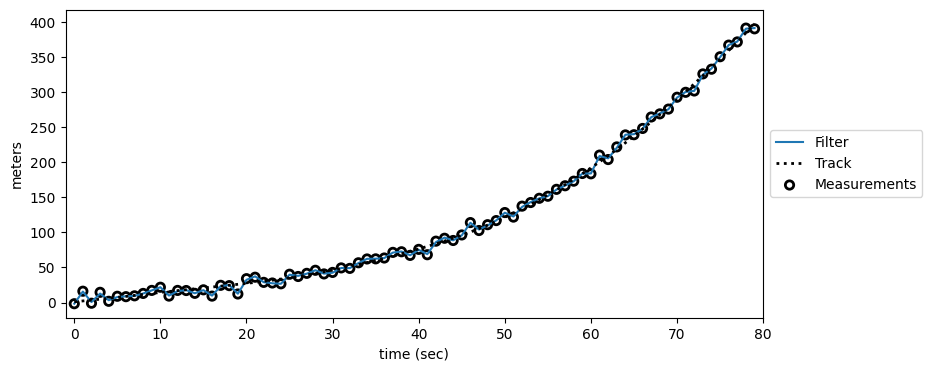

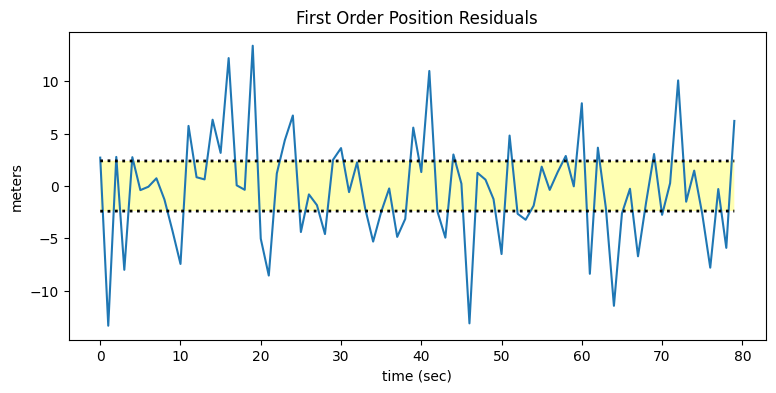

In [29]:
kf4 = FirstOrderKF(R, Q * 10000, dt=1)
data4 = filter_data(kf4, zs)

plot_kf_output(xs, data4.x, data4.z, aspect_equal=False)
plot_residuals(xs[:, 0], data4, 0, 
               'First Order Position Residuals',
               'meters') 

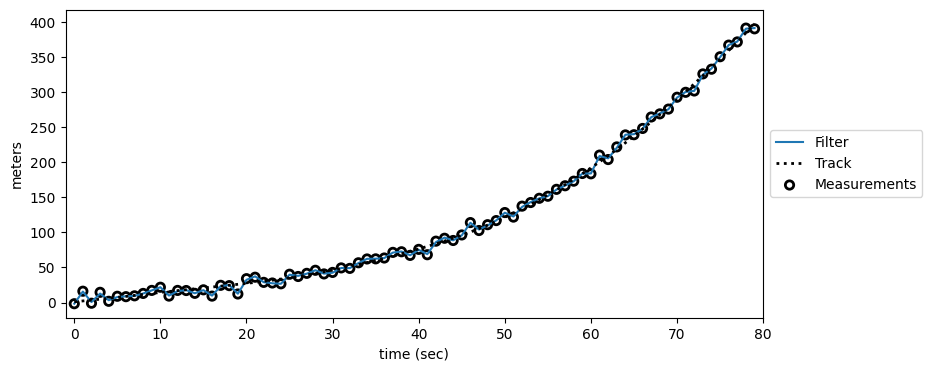

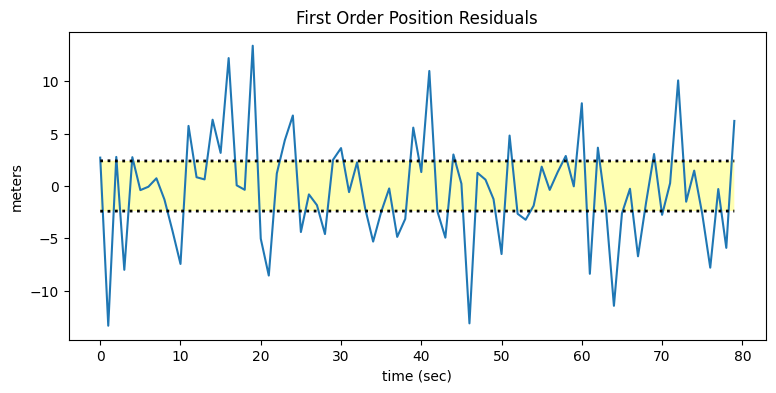

In [30]:
kf4 = FirstOrderKF(R, Q * 10000, dt=1)
data4 = filter_data(kf4, zs)

plot_kf_output(xs, data4.x, data4.z, aspect_equal=False)
plot_residuals(xs[:, 0], data4, 0, 
               'First Order Position Residuals',
               'meters') 

In [31]:
from filterpy.common import kinematic_kf

kf = kinematic_kf(dim=2, order=1, dt=1.0, order_by_dim=False)
kf.Q = np.diag([0, 0, .003, .003])
kf.x = np.array([[1., 1., 0., 0.]]).T
kf.R = np.diag([0.03, 0.21]) # use different errors

for i in range(101):
    kf.predict()
    kf.update(np.array([[i*.05, i*.05]])) # around 200 kph

p0 = kf.x[0:2]

kf.predict()
prior = kf.x
z = kf.x[0:2]*2
kf.update(z)
p1 = kf.x[0:2]

# compute error of measurement from prior
y = np.abs(z - kf.H @ prior)
dist = np.linalg.norm(y)

np.set_printoptions(precision=2, suppress=True)

print(f'bad measurement       : {z.T} km')
print(f'before bad measurement: {p0.T} km')
print(f'after bad measurement : {p1.T} km')
print(f'estimate shift        : {np.linalg.norm(p1 - prior[:2]):.1f} km')
print(f'distance from prior   : {dist:.1f} km')

bad measurement       : [[10.1 10.1]] km
before bad measurement: [[5. 5.]] km
after bad measurement : [[7.84 7.01]] km
estimate shift        : 3.4 km
distance from prior   : 7.1 km


In [32]:
print(f'error = {np.linalg.norm(kf.y):.1f} km, at a speed of {dist*3600:.0f} kph')

error = 7.1 km, at a speed of 25710 kph


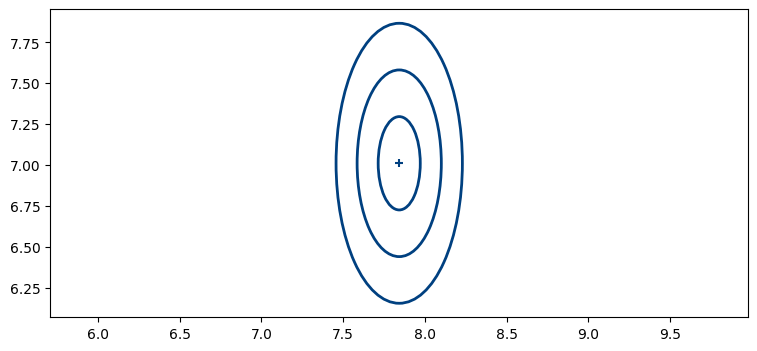

In [33]:
x, P = kf.x[0:2], kf.P[0:2, 0:2]
plot_covariance_ellipse(x, P, std=[1,2,3])

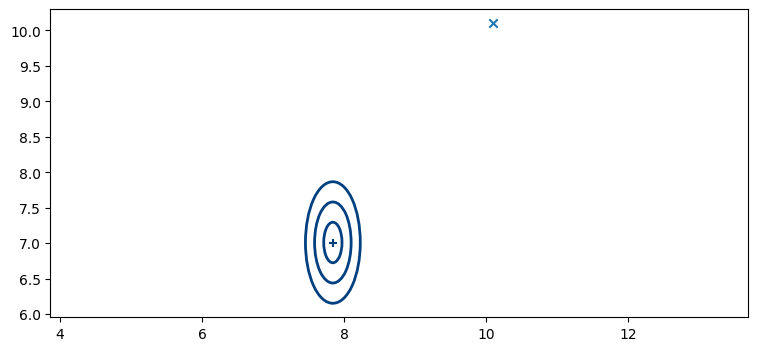

In [34]:
plot_covariance_ellipse(x, P, std=[1,2,3])
plt.scatter(z[0], z[1], marker='x');

In [35]:
GATE_LIMIT = 4.
std_x = np.sqrt(P[0,0])
std_y = np.sqrt(P[1,1])
y = kf.residual_of(z)[:,0]

if y[0] > GATE_LIMIT * std_x or y[1] > GATE_LIMIT * std_y:
    print(f'discarding measurement, error is {y[0]/std_x:.0f} std, {y[1]/std_y:.0f} std')
    
print('y   is', y)
print(f'std is {std_x:.2f} {std_y:.2f}')

discarding measurement, error is 39 std, 18 std
y   is [5.05 5.05]
std is 0.13 0.29


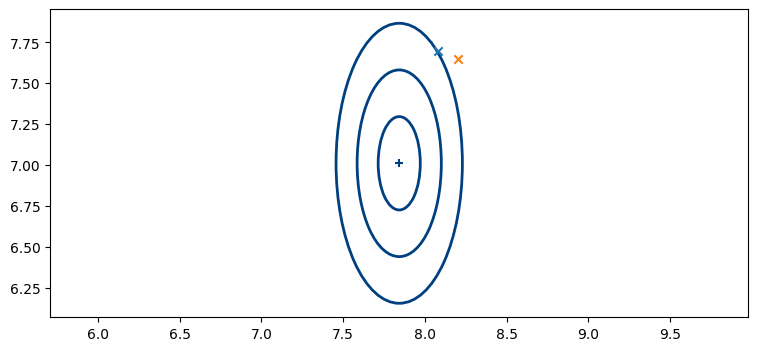

In [36]:
plot_covariance_ellipse(x, P, std=[1,2,3])
plt.scatter(8.08, 7.7, marker='x')
plt.scatter(8.2, 7.65, marker='x');

In [37]:
from filterpy.stats import mahalanobis
m = mahalanobis(x=z, mean=x, cov=P)
print(f'mahalanobis distance = {m:.1f}')

mahalanobis distance = 20.6


In [38]:
from scipy.linalg import inv

def NEES(xs, est_xs, Ps):
    est_err = xs - est_xs
    err = []
    for x, p in zip(est_err, Ps):
        err.append(x.T @ inv(p) @ x)
    return err

R, Q = 6., 0.02
xs, zs = simulate_acc_system(R=R, Q=Q, count=80)
kf2 = SecondOrderKF(R, Q, dt=1)
est_xs, ps, _, _ = kf2.batch_filter(zs)

nees = NEES (xs, est_xs, ps)
eps = np.mean(nees)

print(f'mean NEES is: {eps:.4f}')
if eps < kf2.dim_x:
    print('passed')
else:
    print('failed')

mean NEES is: 1.0411
passed


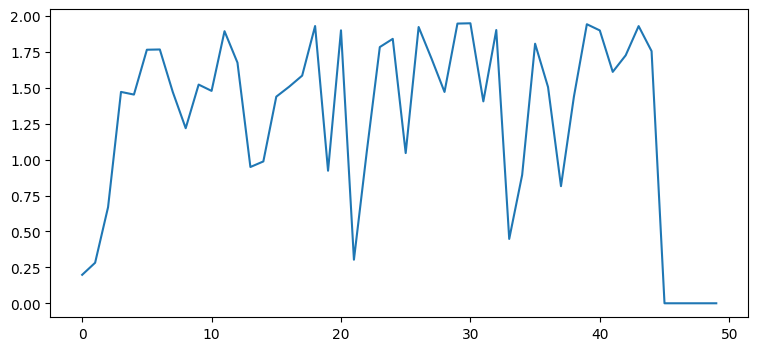

In [39]:
R, Q = .05, 0.02
xs, zs = simulate_acc_system(R=R, Q=Q, count=50)
zs[-5:-1] = [100, 200, 200, 200] # bad measurements, bad!

kf = SecondOrderKF(R, Q, dt=1, P=1)
s = Saver(kf)
kf.batch_filter(zs, saver=s)
plt.plot(s.likelihood);

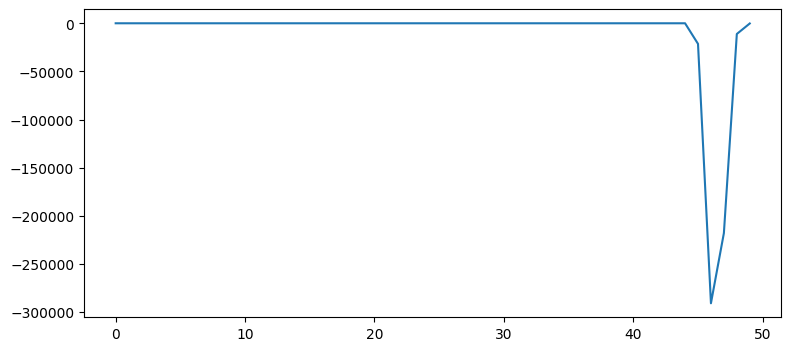

In [40]:
plt.plot(s.log_likelihood);

[[10.  0.]
 [ 0. 10.]]


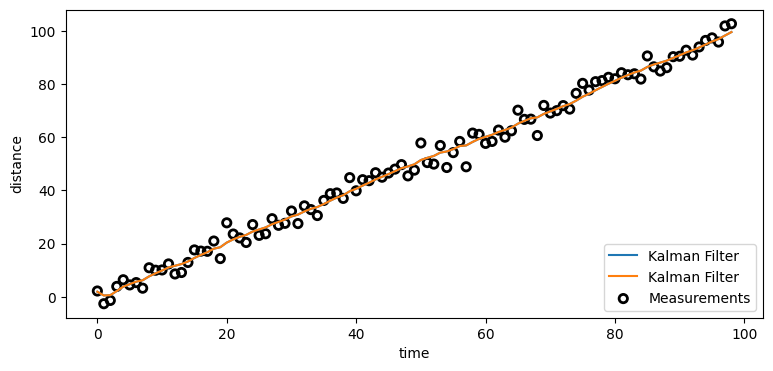

In [41]:
dt = 1.
R = 3.
kf = KalmanFilter(dim_x=2, dim_z=1, dim_u = 1)
kf.P *= 10
kf.R *= R
kf.Q = Q_discrete_white_noise(2, dt, 0.1)
kf.F = np.array([[1., 0], [0., 0.]])
kf.B = np.array([[dt], [ 1.]])
kf.H = np.array([[1., 0]])
print(kf.P)

zs = [i + randn()*R for i in range(1, 100)]
xs = []
cmd_velocity = np.array([1.])
for z in zs:
    kf.predict(u=cmd_velocity)
    kf.update(z)
    xs.append(kf.x[0])

plt.plot(xs, label='Kalman Filter')
plot_measurements(zs)
plt.xlabel('time')
plt.legend(loc=4)
plt.ylabel('distance');

fusion std: 1.647


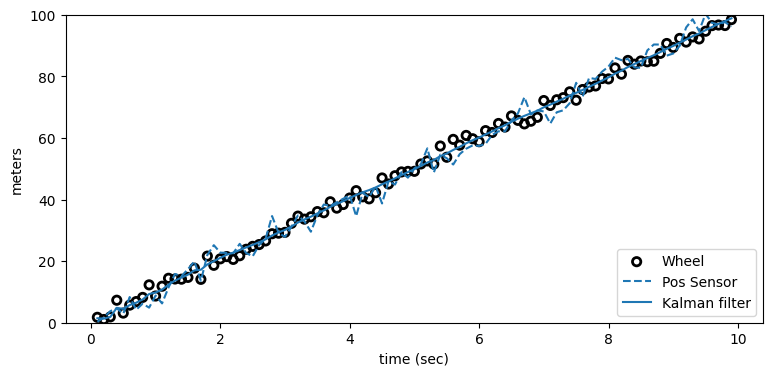

In [42]:
from numpy import array, asarray
import numpy.random as random

def fusion_test(wheel_sigma, ps_sigma, do_plot=True):
    dt = 0.1
    kf = KalmanFilter(dim_x=2, dim_z=2)

    kf.F = array([[1., dt], [0., 1.]])
    kf.H = array([[1., 0.], [1., 0.]])
    kf.x = array([[0.], [1.]])
    kf.Q *= array([[(dt**3)/3, (dt**2)/2],
                   [(dt**2)/2,  dt      ]]) * 0.02
    kf.P *= 100
    kf.R[0, 0] = wheel_sigma**2
    kf.R[1, 1] = ps_sigma**2 
    s = Saver(kf)

    random.seed(1123)
    for i in range(1, 100):
        m0 = i + randn()*wheel_sigma
        m1 = i + randn()*ps_sigma
        kf.predict()
        kf.update(array([[m0], [m1]]))
        s.save()
    s.to_array()
    print(f'fusion std: {np.std(s.y[:, 0]):.3f}')
    if do_plot:
        ts = np.arange(0.1, 10, .1)
        plot_measurements(ts, s.z[:, 0], label='Wheel')
        plt.plot(ts, s.z[:, 1], ls='--', label='Pos Sensor')
        plot_filter(ts, s.x[:, 0], label='Kalman filter')
        plt.legend(loc=4)
        plt.ylim(0, 100)
        set_labels(x='time (sec)', y='meters')

fusion_test(1.5, 3.0)

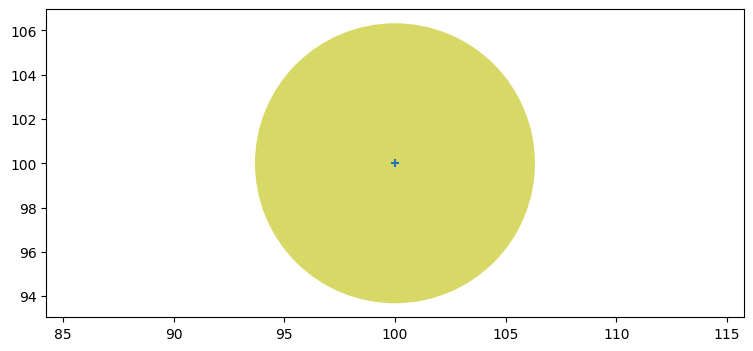

In [44]:
from kf_book.kf_design_internal import sensor_fusion_kf

kf = sensor_fusion_kf()
x0, p0 = kf.x.copy(), kf.P.copy()
plot_covariance_ellipse(x0, p0, fc='y', ec=None, alpha=0.6)

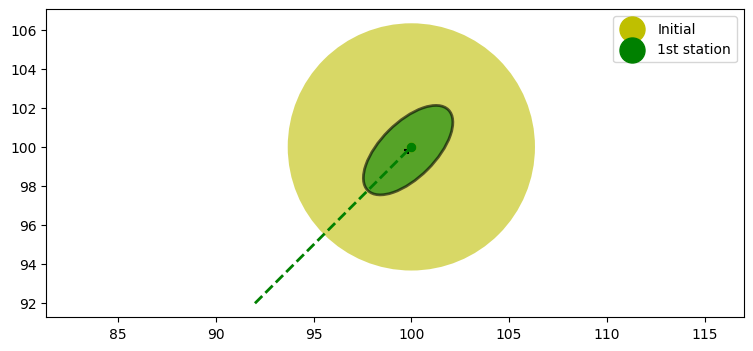

In [45]:
from math import radians
from kf_book.kf_design_internal import sensor_fusion_kf, set_radar_pos

# set the error of the radar's bearing and distance
kf.R[0, 0] = radians (.5)**2
kf.R[1, 1] = 3.**2

# compute position and covariance from first radar station
set_radar_pos((50, 50))
dist = (50**2 + 50**2) ** 0.5
kf.predict()
kf.update([radians(45), dist])

# plot the results
x1, p1 = kf.x.copy(), kf.P.copy()

plot_covariance_ellipse(x0, p0, fc='y', ec=None, alpha=0.6)
plot_covariance_ellipse(x1, p1, fc='g', ec='k', alpha=0.6)

plt.scatter([100], [100], c='y', label='Initial')
plt.scatter([100], [100], c='g', label='1st station')
plt.legend(scatterpoints=1, markerscale=3)
plt.plot([92, 100], [92, 100], c='g', lw=2, ls='--');

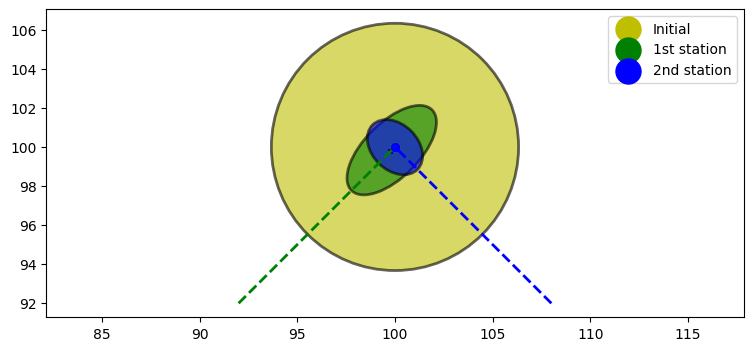

In [46]:
# compute position and covariance from second radar station
set_radar_pos((150, 50))
kf.predict()
kf.update([radians(135), dist])

plot_covariance_ellipse(x0, p0, fc='y', ec='k', alpha=0.6)
plot_covariance_ellipse(x1, p1, fc='g', ec='k', alpha=0.6)
plot_covariance_ellipse(kf.x, kf.P, fc='b', ec='k', alpha=0.6)

plt.scatter([100], [100], c='y', label='Initial')
plt.scatter([100], [100], c='g', label='1st station')
plt.scatter([100], [100], c='b', label='2nd station')
plt.legend(scatterpoints=1, markerscale=3)
plt.plot([92, 100], [92, 100], c='g', lw=2, ls='--')
plt.plot([108, 100], [92, 100], c='b', lw=2, ls='--');

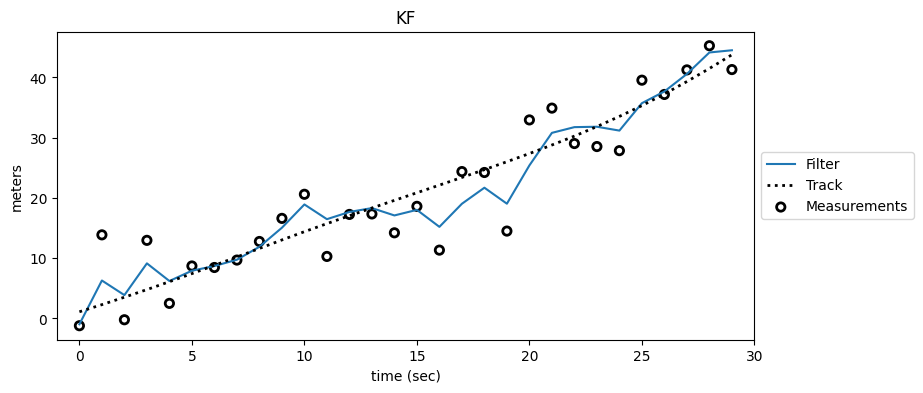

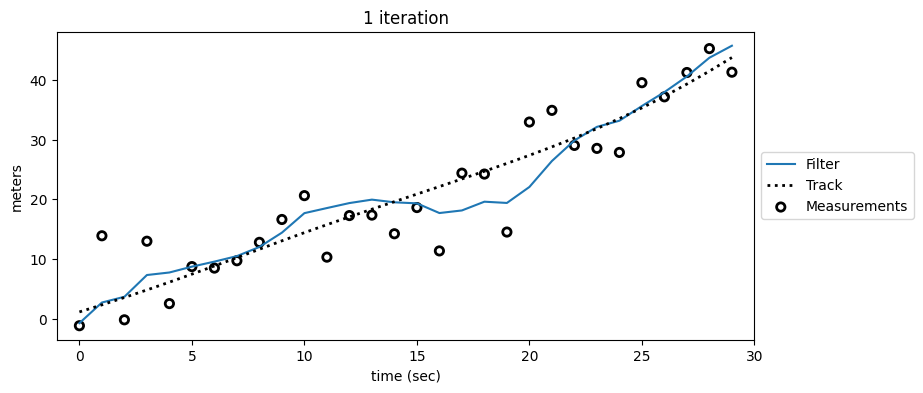

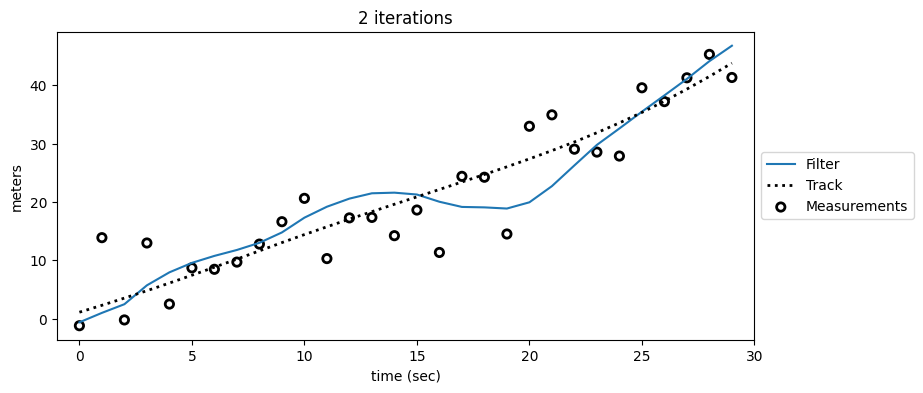

(5.0, 0.02)

In [47]:
np.random.seed(124)
R = 5.
xs, zs = simulate_acc_system(R=R, Q=Q, count=30)

kf0 = SecondOrderKF(R, Q, dt=1)
kf1 = SecondOrderKF(R, Q, dt=1)
kf2 = SecondOrderKF(R, Q, dt=1)

# Filter measurements
fxs0, ps0, _, _ = kf0.batch_filter(zs)

# filter twice more, using the state as the input
fxs1, ps1, _, _ = kf1.batch_filter(fxs0[:, 0])
fxs2, _, _, _ = kf2.batch_filter(fxs1[:, 0])

plot_kf_output(xs, fxs0, zs, 'KF', False)
plot_kf_output(xs, fxs1, zs, '1 iteration', False)
plot_kf_output(xs, fxs2, zs, '2 iterations', False)
R,Q

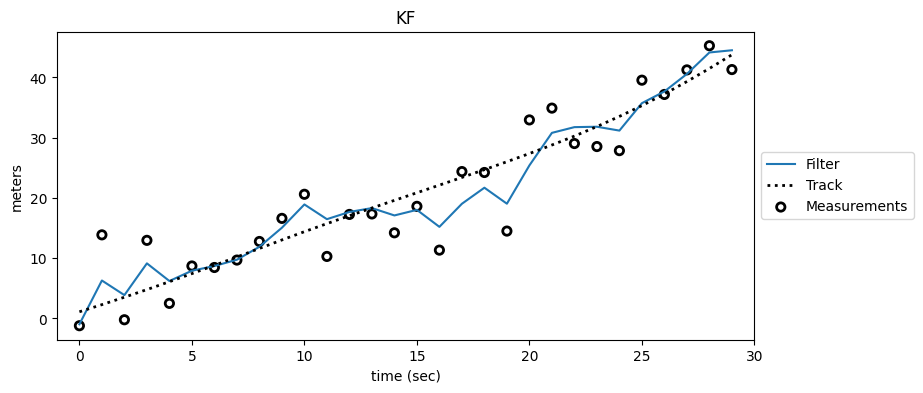

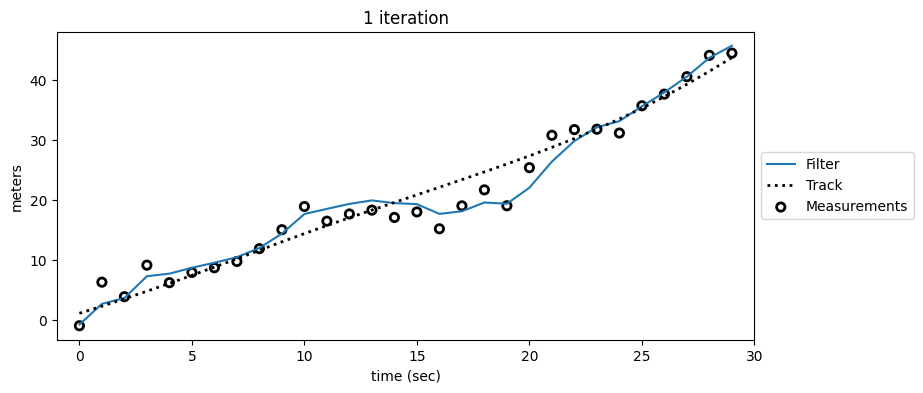

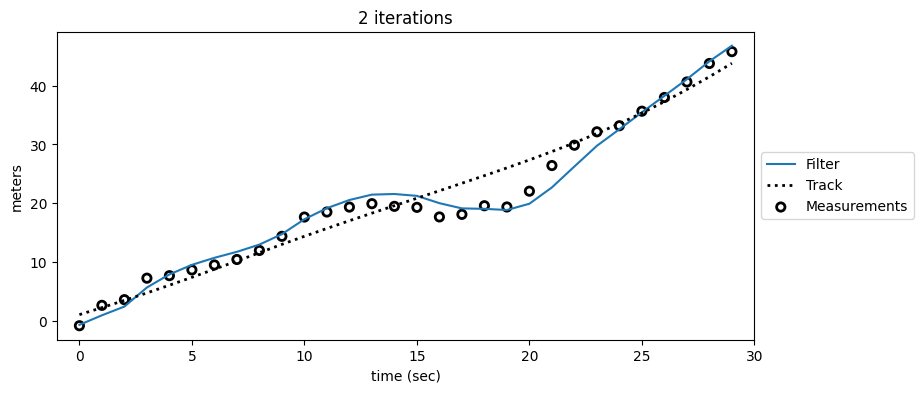

In [48]:
plot_kf_output(xs, fxs0, zs, title='KF', aspect_equal=False)
plot_kf_output(xs, fxs1, fxs0[:, 0], '1 iteration', False)
plot_kf_output(xs, fxs2, fxs1[:, 0], '2 iterations', False)

In [49]:
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = array([0., 1.])
kf.H = array([[1, 0]])
kf.P = np.eye(2) * 50
kf.R = np.eye(1)
q_var = 0.02

# measurement tuple: (value, time)
zs = [(1., 1.),  (2., 1.1), (3., 0.9), (4.1, 1.23), (5.01, 0.97)]
for z, dt in zs:
    kf.F = array([[1, dt],
                  [0, 1]])
    kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=q_var)
    kf.predict()
    kf.update(z)
    print(kf.x)

[1. 1.]
[2.   0.92]
[2.96 1.  ]
[4.12 0.97]
[5.03 0.96]


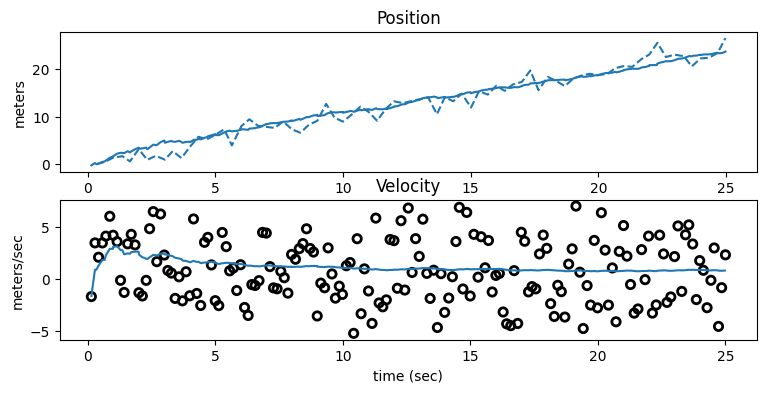

In [50]:
def gen_sensor_data(t, ps_std, wheel_std):
    # generate simulated sensor data
    pos_data, vel_data = [], []
    dt = 0.
    for i in range(t*3):
        dt += 1/3.
        t_i = dt + randn() * .01 # time jitter
        pos_data.append([t_i, t_i + randn()*ps_std])

    dt = 0.    
    for i in range(t*7):
        dt += 1/7.
        t_i = dt + randn() * .006 # time jitter
        vel_data.append([t_i, 1. + randn()*wheel_std])
    return pos_data, vel_data


def plot_fusion(xs, ts, zs_ps, zs_wheel):
    xs = np.array(xs)
    plt.subplot(211)
    plt.plot(zs_ps[:, 0], zs_ps[:, 1], ls='--', label='Pos Sensor')
    plot_filter(xs=ts, ys=xs[:, 0], label='Kalman filter')
    set_labels(title='Position', y='meters',)

    plt.subplot(212)
    plot_measurements(zs_wheel[:, 0], zs_wheel[:, 1],  label='Wheel')
    plot_filter(xs=ts, ys=xs[:, 1], label='Kalman filter')
    set_labels('Velocity', 'time (sec)', 'meters/sec')
    

def fusion_test(pos_data, vel_data, wheel_std, ps_std):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.F = array([[1., 1.], [0., 1.]])
    kf.H = array([[1., 0.], [1., 0.]])
    kf.x = array([[0.], [1.]])
    kf.P *= 100

    xs, ts = [],  []
    
    # copy data for plotting
    zs_wheel = np.array(vel_data)
    zs_ps = np.array(pos_data)
                     
    last_t = 0
    while len(pos_data) > 0 and len(vel_data) > 0:
        if pos_data[0][0] < vel_data[0][0]:
            t, z = pos_data.pop(0)
            dt = t - last_t
            last_t = t
            
            kf.H = np.array([[1., 0.]])
            kf.R[0,0] = ps_std**2
        else:
            t, z = vel_data.pop(0)
            dt = t - last_t
            last_t = t
            
            kf.H = np.array([[0., 1.]])
            kf.R[0,0] = wheel_std**2

        kf.F[0,1] = dt
        kf.Q = Q_discrete_white_noise(2, dt=dt, var=.02)
        kf.predict()
        kf.update(np.array([z]))

        xs.append(kf.x.T[0])
        ts.append(t)
    plot_fusion(xs, ts, zs_ps, zs_wheel)

random.seed(1123)
pos_data, vel_data = gen_sensor_data(25, 1.5, 3.0)
fusion_test(pos_data, vel_data, 1.5, 3.0);

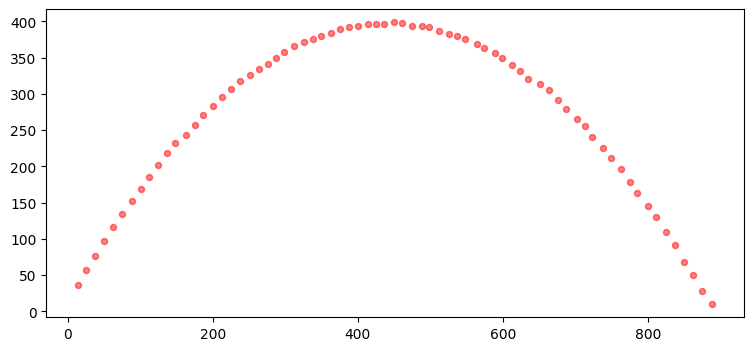

In [52]:
from math import radians, sin, cos
import math

def rk4(y, x, dx, f):
    """computes 4th order Runge-Kutta for dy/dx.
    y is the initial value for y
    x is the initial value for x
    dx is the difference in x (e.g. the time step)
    f is a callable function (y, x) that you supply to 
      compute dy/dx for the specified values.
    """
    
    k1 = dx * f(y, x)
    k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
    k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
    k4 = dx * f(y + k3, x + dx)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

def fx(x,t):
    return fx.vel
    
def fy(y,t):
    return fy.vel - 9.8*t


class BallTrajectory2D(object):
    def __init__(self, x0, y0, velocity, 
                 theta_deg=0., 
                 g=9.8, 
                 noise=[0.0, 0.0]):
        self.x = x0
        self.y = y0
        self.t = 0        
        theta = math.radians(theta_deg)
        fx.vel = math.cos(theta) * velocity
        fy.vel = math.sin(theta) * velocity        
        self.g = g
        self.noise = noise
        
        
    def step(self, dt):
        self.x = rk4(self.x, self.t, dt, fx)
        self.y = rk4(self.y, self.t, dt, fy)
        self.t += dt 
        return (self.x + randn()*self.noise[0], 
                self.y + randn()*self.noise[1])
    
def test_ball_vacuum(noise):
    y = 15
    x = 0
    ball = BallTrajectory2D(x0=x, y0=y, 
                            theta_deg=60., velocity=100., 
                            noise=noise)
    t = 0
    dt = 0.25
    while y >= 0:
        x, y = ball.step(dt)
        t += dt
        if y >= 0:
            plt.scatter(x, y, color='r', marker='.', s=75, alpha=0.5)
         
    plt.axis('equal');
    
#test_ball_vacuum([0, 0]) # plot ideal ball position
test_ball_vacuum([1, 1]) # plot with noise 

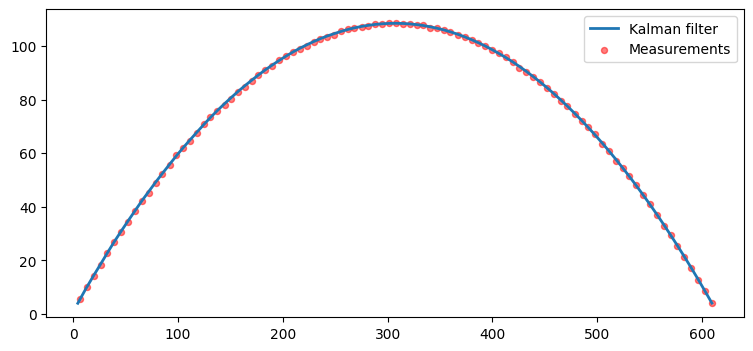

In [54]:
from math import sin, cos, radians

def ball_kf(x, y, omega, v0, dt, r=0.5, q=0.):
    kf = KalmanFilter(dim_x=4, dim_z=2, dim_u=1)

    kf.F = np.array([[1., dt, 0., 0.],   # x   = x0 + dx*dt
                     [0., 1., 0., 0.],   # dx  = dx0
                     [0., 0., 1., dt],   # y   = y0 + dy*dt
                     [0., 0., 0., 1.]])  # dy  = dy0

    kf.H = np.array([[1., 0., 0., 0.],
                     [0., 0., 1., 0.]])
    
    kf.B = np.array([[0., 0., 0., dt]]).T
    kf.R *= r
    kf.Q *= q

    omega = radians(omega)
    vx = cos(omega) * v0
    vy = sin(omega) * v0
    kf.x = np.array([[x, vx, y, vy]]).T
    return kf

def track_ball_vacuum(dt):
    global kf
    x, y = 0., 1.
    theta = 35.  # launch angle
    v0 = 80.
    g = np.array([[-9.8]])  # gravitational constant
    ball = BallTrajectory2D(x0=x, y0=y, theta_deg=theta, velocity=v0, 
                            noise=[.2, .2])
    kf = ball_kf(x, y, theta, v0, dt)

    t = 0
    xs, ys = [], []
    while kf.x[2] > 0:
        t += dt
        x, y = ball.step(dt)
        z = np.array([[x, y]]).T

        kf.update(z)
        xs.append(kf.x[0])
        ys.append(kf.x[2])    
        kf.predict(u=g)     
        p1 = plt.scatter(x, y, color='r', marker='.', s=75, alpha=0.5)
    p2, = plt.plot(xs, ys, lw=2)
    plt.legend([p2, p1], ['Kalman filter', 'Measurements'],
               scatterpoints=1)
    
track_ball_vacuum(dt=1./10)

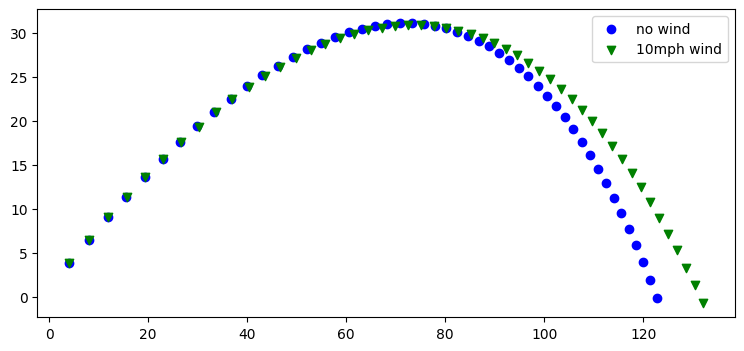

In [55]:
from math import sqrt, exp

def mph_to_mps(x):
    return x * .447

def drag_force(velocity):
    """ Returns the force on a baseball due to air drag at
    the specified velocity. Units are SI"""

    return velocity * (0.0039 + 0.0058 / 
            (1. + exp((velocity-35.)/5.)))

v = mph_to_mps(110.)
x, y = 0., 1.
dt = .1
theta = radians(35)

def solve(x, y, vel, v_wind, launch_angle):
    xs = []
    ys = []
    v_x = vel*cos(launch_angle)
    v_y = vel*sin(launch_angle)
    while y >= 0:
        # Euler equations for x and y
        x += v_x*dt
        y += v_y*dt

        # force due to air drag    
        velocity = sqrt((v_x-v_wind)**2 + v_y**2)    
        F = drag_force(velocity)

        # euler's equations for vx and vy
        v_x = v_x - F*(v_x-v_wind)*dt
        v_y = v_y - 9.8*dt - F*v_y*dt
        
        xs.append(x)
        ys.append(y)
    
    return xs, ys
        
x, y = solve(x=0, y=1, vel=v, v_wind=0, launch_angle=theta)
p1 = plt.scatter(x, y, color='blue', label='no wind')

wind = mph_to_mps(10)
x, y = solve(x=0, y=1, vel=v, v_wind=wind, launch_angle=theta)
p2 = plt.scatter(x, y, color='green', marker="v", 
                 label='10mph wind')
plt.legend(scatterpoints=1);

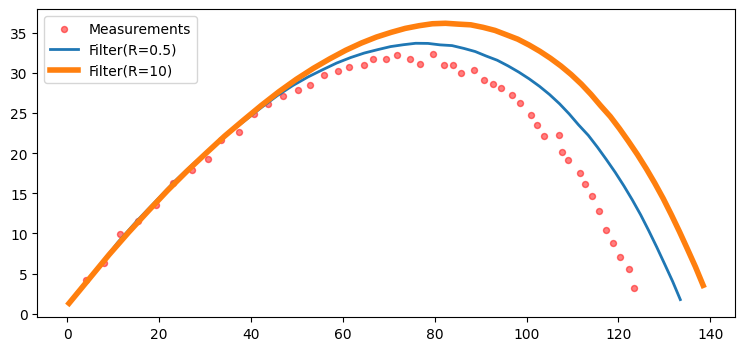

In [57]:
class BaseballPath:
    def __init__(self, x0, y0, launch_angle_deg, velocity_ms, 
                 noise=(1.0, 1.0)): 
        """ Create 2D baseball path object  
           (x = distance from start point in ground plane, 
            y=height above ground)
        
        x0,y0            initial position
        launch_angle_deg angle ball is travelling respective to 
                         ground plane
        velocity_ms      speeed of ball in meters/second
        noise            amount of noise to add to each position
                         in (x, y)
        """
        
        omega = radians(launch_angle_deg)
        self.v_x = velocity_ms * cos(omega)
        self.v_y = velocity_ms * sin(omega)

        self.x = x0
        self.y = y0
        self.noise = noise


    def drag_force(self, velocity):
        """ Returns the force on a baseball due to air drag at
        the specified velocity. Units are SI
        """
        B_m = 0.0039 + 0.0058 / (1. + exp((velocity-35.)/5.))
        return B_m * velocity


    def update(self, dt, vel_wind=0.):
        """ compute the ball position based on the specified time 
        step and wind velocity. Returns (x, y) position tuple.
        """

        # Euler equations for x and y
        self.x += self.v_x*dt
        self.y += self.v_y*dt

        # force due to air drag
        v_x_wind = self.v_x - vel_wind
        v = sqrt(v_x_wind**2 + self.v_y**2)
        F = self.drag_force(v)

        # Euler's equations for velocity
        self.v_x = self.v_x - F*v_x_wind*dt
        self.v_y = self.v_y - 9.81*dt - F*self.v_y*dt

        return (self.x + randn()*self.noise[0], 
                self.y + randn()*self.noise[1])
    
x, y = 0, 1.

theta = 35. # launch angle
v0 = 50.
dt = 1/10.   # time step
g = np.array([[-9.8]])

plt.figure()
ball = BaseballPath(x0=x, y0=y, launch_angle_deg=theta,
                    velocity_ms=v0, noise=[.3,.3])
f1 = ball_kf(x, y, theta, v0, dt, r=1.)
f2 = ball_kf(x, y, theta, v0, dt, r=10.)
t = 0
xs, ys = [], []
xs2, ys2 = [], []

while f1.x[2] > 0:
    t += dt
    x, y = ball.update(dt)
    z = np.array([[x, y]]).T

    f1.update(z)
    f2.update(z)
    xs.append(f1.x[0])
    ys.append(f1.x[2])
    xs2.append(f2.x[0])
    ys2.append(f2.x[2])    
    f1.predict(u=g) 
    f2.predict(u=g)
    
    p1 = plt.scatter(x, y, color='r', marker='.', s=75, alpha=0.5)

p2, = plt.plot(xs, ys, lw=2)
p3, = plt.plot(xs2, ys2, lw=4)
plt.legend([p1, p2, p3], 
           ['Measurements', 'Filter(R=0.5)', 'Filter(R=10)'],
           loc='best', scatterpoints=1);

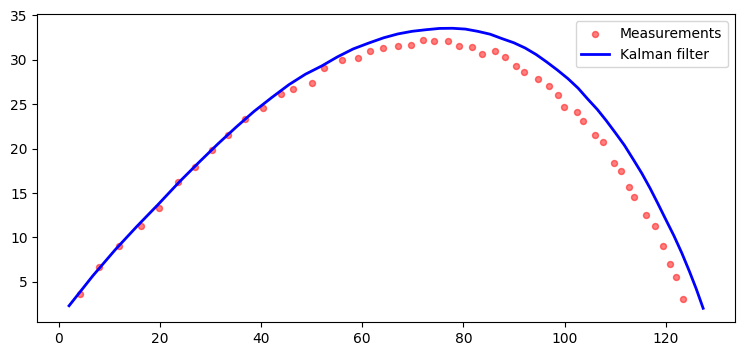

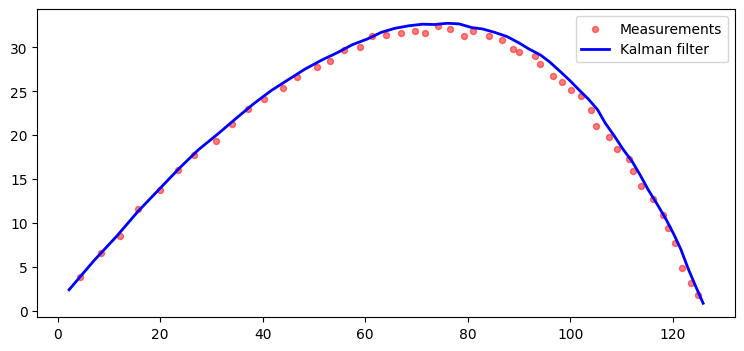

In [58]:
def plot_ball_with_q(q, r=1., noise=0.3):
    x, y = 0., 1.
    theta = 35. # launch angle
    v0 = 50.
    dt = 1/10.   # time step
    g = np.array([[-9.8]])

    ball = BaseballPath(x0=x, 
                        y0=y, 
                        launch_angle_deg=theta, 
                        velocity_ms=v0, 
                        noise=[noise,noise])
    f1 = ball_kf(x, y, theta, v0, dt, r=r, q=q)
    t = 0
    xs, ys = [], []

    while f1.x[2] > 0:
        t += dt
        x, y = ball.update(dt)
        z = np.array([[x, y]]).T

        f1.update(z)
        xs.append(f1.x[0])
        ys.append(f1.x[2]) 
        f1.predict(u=g) 

        p1 = plt.scatter(x, y, c='r', marker='.', s=75, alpha=0.5)

    p2, = plt.plot(xs, ys, lw=2, color='b')
    plt.legend([p1, p2], ['Measurements', 'Kalman filter'])
    plt.show()

plot_ball_with_q(0.01)
plot_ball_with_q(0.1)

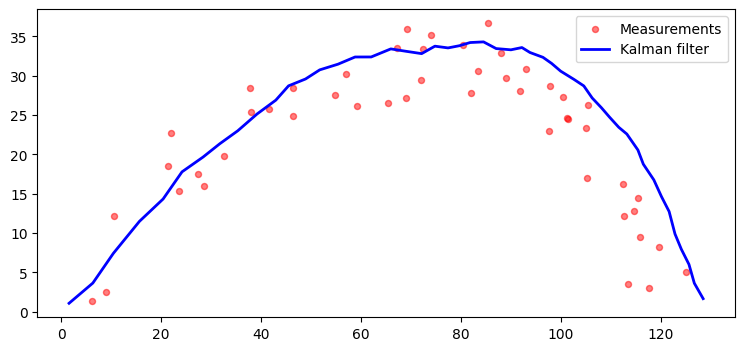

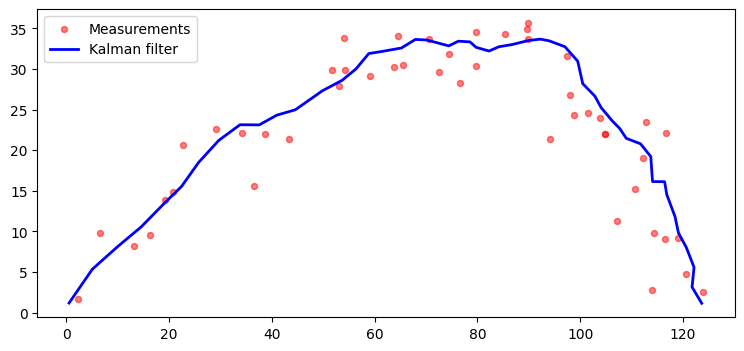

In [59]:
plot_ball_with_q(0.01, r=3, noise=3.)
plot_ball_with_q(0.1, r=3, noise=3.)